# Checksum Validation and Verification ( adler32 )

- **Validation**: 
    - For the DIDs that were present in both, rucio dumps and seal dumps, we will first make sure that SEAL has provided the checksums for all the DIDs that were uploaded to the storage element and were claimed to be available by SEAL. These DIDs are the ones that are present in the rucio dumps and the seal dumps.
    - We will then report the DIDs for which the checksums are missing in the seal dumps. SEAL must provide the checksums for these missing DIDs in order to verify the integrity of the data.

- **Verification**: For the subset of DIDs that are available in both the rucio dumps and the seal dumps and have the checksums available in the seal dumps, we will verify the checksums in Rucio against the checksums provided by SEAL.

## Time Range
We need to pick a time range used to filter the DIDs from the dumps. The end time is limited by the fact that we do not have all the checksums for the DIDs in the SEAL dumps after a certain time. We will use the following time range for the analysis:

In [2]:
from datetime import datetime
date_start_str = '20220101' # YYYYMMDD
date_end_str = '20230101' # YYYYMMDD

date_start = datetime.strptime(date_start_str, '%Y%m%d')
date_end = datetime.strptime(date_end_str, '%Y%m%d')

# Checksum Validation

In this section, we will process the checksums from the Rucio and SEAL dumps to make them comparable. As a reminder, we prepare a subset of the consistent DIDs for which checksums are available from Rucio and SEAL.

## Checksums calculated by SEAL

The `data/seal/checksums/entries_{start_date}_{end_date}.csv` file contains the checksums (adler32, md5, sha256) calculated by SEAL for the DIDs available on their storage. 


In [3]:
import pandas as pd
from infratructure.repository.data_repository import list_files
from datetime import datetime
from core.entity import TimeRangeSourceData
dir="data/seal/checksums"
data_files = list_files(dir)
# sort file by name
data_files.sort()
data_files = [x.split('.')[0] for x in data_files]
entries_time_series_source_data = []
errors_time_series_source_data = []
for file in data_files:
    type, start_date, end_date = file.split('_')
    start_date = datetime.strptime(start_date, '%Y%m%d')
    end_date = datetime.strptime(end_date, '%Y%m%d')
    df = pd.read_csv(f"{dir}/{file}.csv")
    if type == "entries":
        entries_time_series_source_data.append(TimeRangeSourceData(start=start_date, end=end_date, df=df, source="SEAL_ENTRIES", file=f"{dir}/{file}.csv"))
    if type == "errors":
        errors_time_series_source_data.append(TimeRangeSourceData(start=start_date, end=end_date, df=df, source="SEAL_ERRORS", file=f"{dir}/{file}.csv"))


In [4]:
# check if the entrires form a continuous time range
for i in range(1, len(entries_time_series_source_data)):
    if entries_time_series_source_data[i].start != entries_time_series_source_data[i-1].end:
        print(f"Continuity Error: {entries_time_series_source_data[i-1].end} != {entries_time_series_source_data[i].start}")
        print(f"Check files {entries_time_series_source_data[i-1].file} and {entries_time_series_source_data[i].file}")

# check if the errors form a continuous time range
for i in range(1, len(errors_time_series_source_data)):
    if errors_time_series_source_data[i].start != errors_time_series_source_data[i-1].end:
        print(f"Continuity Error: {errors_time_series_source_data[i-1].end} != {errors_time_series_source_data[i].start}")
        print(f"Check files {errors_time_series_source_data[i-1].file} and {errors_time_series_source_data[i].file}")


## Data aggregation: Merge data across different time ranges ( Errors and Entries)

In [5]:
entries = pd.concat([x.df for x in entries_time_series_source_data])
errors = pd.concat([x.df for x in errors_time_series_source_data])

# sort by created time
entries = entries.sort_values(by='created')
errors = errors.sort_values(by='created')

# convert created to datetime
entries['created'] = pd.to_datetime(entries['created'])
errors['created'] = pd.to_datetime(errors['created'], errors = 'coerce') # some errors have invalid created time 

# add month column
entries['month'] = entries['created'].dt.month
errors['month'] = errors['created'].dt.month

# add year column
entries['year'] = entries['created'].dt.year
errors['year'] = errors['created'].dt.year

/var/folders/0x/zbc_xnv17ggfqczysm3_5g_80000gn/T/ipykernel_85622/2725483414.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  errors['created'] = pd.to_datetime(errors['created'], errors = 'coerce') # some errors have invalid created time


### Data Analysis
We can now start with the analysis of the data.

In [6]:
import pandas as pd
from core.utils import bytesToTB

entries['path'] = entries['path'].str.replace('rucio/', '')

total_size_entries = entries['size_bytes'].sum()

print(f'Num Entries: {entries.shape[0]}')
print(f'Total Size: {bytesToTB(total_size_entries)} TB')

Num Entries: 1542871
Total Size: 1277.133 TB


The `data/seal/checksums/errors_{start_date}_{end_date}.csv` file contains entries that for which the checksum could not be calculated by SEAL and the specific errors that occurred.

- Most of the errors indicate 404 Not Found, which means SEAL has data for the file, but the last few chunks did not complete transfer
- Entries with a 500 Internal Server Error are essentially the same as the 404, but the in addition the to the chunk(s) missing, the metadata record could not be found

In [7]:
errors['path'] = errors['path'].str.replace('rucio/', '')
print(f'Num Errors: {errors.shape[0]}')

Num Errors: 11478


## Checksums stored by Rucio

We will load the consistent did's ( subset of rucio dumps ) and filter for rows for the selected time range. The consistent did's are the ones that are present in both the rucio dumps and the seal dumps. This file was prepared in the `manual_auditor` notebook.

In [8]:
consistent_dids_file = f'data/outputs/20220101-20230410_consistent_dids.csv'
consistent_dids = pd.read_csv(consistent_dids_file)

consistent_dids['creation_date'] = pd.to_datetime(consistent_dids['creation_date'])
consistent_dids['update_date'] = pd.to_datetime(consistent_dids['update_date'])
consistent_dids['size'] = pd.to_numeric(consistent_dids['size'])

consistent_dids["month"] = consistent_dids['creation_date'].dt.month
consistent_dids["year"] = consistent_dids['creation_date'].dt.year

print(f'Num Consistent DIDs: {consistent_dids.shape[0]}')

Num Consistent DIDs: 2654663


Now, we filter the consistent did's for the selected time range.

In [9]:
consistent_dids_in_time_range = consistent_dids[(consistent_dids['creation_date'] <= date_end)]

print(f'Num Consistent DIDs in Date Range: {consistent_dids_in_time_range.shape[0]}')

Num Consistent DIDs in Date Range: 2345284


## Missing Checksums from SEAL

The `consistent_dids_in_time_range` DataFrame contains the DIDs that are present in both the rucio dumps and the seal dumps in the selected time range. Therefore, the DIDs provided by SEAL in their `entries` and `errors` DataFrames should also be present in the `consistent_dids_in_time_range` DataFrame ( except for the `dark_dids`). We will check if this is the case.

The entries that are present in the `consistent_dids_in_time_range` file but are not present in the `entries` or `errors` files are missing checksums from SEAL. We will check if there are any such entries.

In [10]:
dids_missing_checksums = consistent_dids_in_time_range[~consistent_dids_in_time_range['path'].isin(entries['path'])]
print(f"DIDs missing in entries file: {len(dids_missing_checksums)}")
# check if the dids missing checksums are not in the errors

dids_missing_checksums = dids_missing_checksums[~dids_missing_checksums['path'].isin(errors['path'])]

print(f'Num Missing Checksums from SEAL: {len(dids_missing_checksums)}')



DIDs missing in entries file: 802624
Num Missing Checksums from SEAL: 802624


## Validation Summary

In [11]:
print(f"For the time range {date_start} to {date_end}: {bytesToTB(consistent_dids_in_time_range['size'].sum())} TB registered in Rucio were available at SEAL.")
print(f"Of these, valid checksums were provided by SEAL for {bytesToTB(entries['size_bytes'].sum())} TB. SEAL could not generate checksums for {bytesToTB(errors['size_bytes'].sum())} TB and these files should be marked as lost.")
print(f"{bytesToTB(dids_missing_checksums['size'].sum())} TB were missing checksums from SEAL.")
print(f"Checksum verification can only be done for {bytesToTB(consistent_dids_in_time_range['size'].sum()) - bytesToTB(dids_missing_checksums['size'].sum()) - bytesToTB(errors['size_bytes'].sum())}/{bytesToTB(consistent_dids_in_time_range['size'].sum())} TB.")

For the time range 2022-01-01 00:00:00 to 2023-01-01 00:00:00: 2629.288 TB registered in Rucio were available at SEAL.
Of these, valid checksums were provided by SEAL for 1277.133 TB. SEAL could not generate checksums for 0.0 TB and these files should be marked as lost.
1352.157 TB were missing checksums from SEAL.
Checksum verification can only be done for 1277.131/2629.288 TB.


In [12]:
print(f"For the time range {date_start} to {date_end}: {len(consistent_dids_in_time_range)} DIDs registered in Rucio were available at SEAL.")
print(f"Of these, valid checksums were provided by SEAL for {len(entries)} DIDs. SEAL could not generate checksums for {len(errors)} DIDs and these files should be marked as lost.")
print(f"{len(dids_missing_checksums)} DIDs were missing checksums from SEAL.")
print(f"Checksum verification can only be done for {len(consistent_dids_in_time_range) - len(dids_missing_checksums) - len(errors)}/{len(consistent_dids_in_time_range)} DIDs.")

For the time range 2022-01-01 00:00:00 to 2023-01-01 00:00:00: 2345284 DIDs registered in Rucio were available at SEAL.
Of these, valid checksums were provided by SEAL for 1542871 DIDs. SEAL could not generate checksums for 11478 DIDs and these files should be marked as lost.
802624 DIDs were missing checksums from SEAL.
Checksum verification can only be done for 1531182/2345284 DIDs.


Text(0.5, 1.0, 'Total: 2629.288 TB')

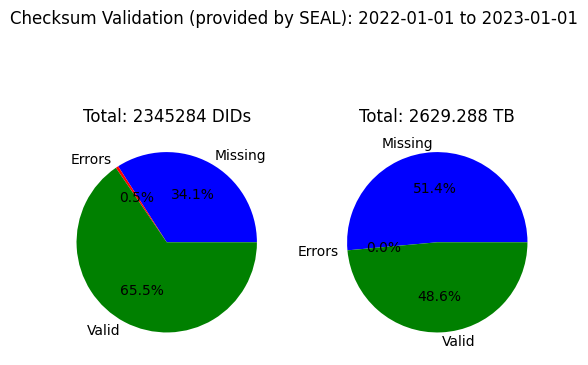

In [13]:
import matplotlib.pyplot as plt
pd.options.plotting.backend='matplotlib'


fig, axs = plt.subplots(1, 2)

fig.suptitle(f'Checksum Validation (provided by SEAL): {date_start.strftime("%Y-%m-%d")} to {date_end.strftime("%Y-%m-%d")}')

axs[0].pie([len(dids_missing_checksums), len(errors), len(entries)], labels=['Missing', 'Errors', 'Valid'], autopct='%1.1f%%', colors=['blue', 'red', 'green'])
axs[0].set_title(f'Total: {len(consistent_dids_in_time_range)} DIDs')

axs[1].pie([bytesToTB(dids_missing_checksums['size'].sum()), bytesToTB(errors['size_bytes'].sum()), bytesToTB(entries['size_bytes'].sum())], labels=['Missing', 'Errors', 'Valid'], autopct='%1.1f%%', colors=['blue', 'red', 'green'])
axs[1].set_title(f'Total: {bytesToTB(consistent_dids_in_time_range["size"].sum())} TB')


In [14]:
missing_checksums_filename = f'data/outputs/{date_start_str}-{date_end_str}_dids_missing_checksums.csv'
dids_missing_checksums.to_csv(missing_checksums_filename, index=False)
print(f"Missing checksums DIDs written to {missing_checksums_filename}")

Missing checksums DIDs written to data/outputs/20220101-20230101_dids_missing_checksums.csv


# Checksum Verification

This section summarizes the checksum verification ( NOT VALIDATION) results. The verification process takes the validated checksums and checks if the checksum reported by Rucio and SEAL actually match.

In [15]:
checksum_verification_df = consistent_dids_in_time_range[consistent_dids_in_time_range['path'].isin(entries['path'])]
print(f"For the time range {date_start} to {date_end}:")
print(f"Checksum verification can be done for {checksum_verification_df.shape[0]} DIDs.")

For the time range 2022-01-01 00:00:00 to 2023-01-01 00:00:00:
Checksum verification can be done for 1542660 DIDs.


In [16]:
df_merged_checksum_data = checksum_verification_df.merge(entries, on='path')
df_merged_checksum_data['checksum_match'] = df_merged_checksum_data['checksum'] == df_merged_checksum_data['hash_adler32']

# count the number of checksums that match
df_verified_replicas = df_merged_checksum_data[df_merged_checksum_data['checksum_match'] == True]
df_bad_replicas = df_merged_checksum_data[df_merged_checksum_data['checksum_match'] == False]

checksum_match_count = df_verified_replicas.shape[0]
checksum_mismatch_count = df_bad_replicas.shape[0]


## Analysis by Number of DIDs

In [17]:
print(f"Checksum verification results ( number of DIDs ):")
print(f"Time Range {date_start} to {date_end}")

num_potential_checksum_verification = len(consistent_dids_in_time_range)
num_missing_checksums = len(dids_missing_checksums)
num_errors = len(errors)
num_verifiable = checksum_verification_df.shape[0]
num_verified_checksums = checksum_match_count
num_mismatch_checksums = checksum_mismatch_count



print(f"Potential DIDs for checksum verification: {num_potential_checksum_verification}")
print(f"Missing checksum information: {num_missing_checksums}")
print(f"Errors: {num_errors}")
print(f"Total verifiable DIDs: {num_verifiable}")
print(f"Verified Replicas (matching checksums): {num_verified_checksums}")
print(f"Checksum Mismatch: {num_mismatch_checksums}")

Checksum verification results ( number of DIDs ):
Time Range 2022-01-01 00:00:00 to 2023-01-01 00:00:00
Potential DIDs for checksum verification: 2345284
Missing checksum information: 802624
Errors: 11478
Total verifiable DIDs: 1542660
Verified Replicas (matching checksums): 1538025
Checksum Mismatch: 4635


## Analysis by Size of DIDs

In [18]:
print(f"Checksum Verification Results (Size): ")
print(f"Time Range {date_start} to {date_end}")

size_potential_checksum_verification = bytesToTB(consistent_dids_in_time_range['size'].sum())
size_missing_checksum = bytesToTB(dids_missing_checksums['size'].sum())
size_errors = bytesToTB(errors['size_bytes'].sum())
size_verifiable = bytesToTB(checksum_verification_df['size'].sum())
size_verified = bytesToTB(df_verified_replicas['size_x'].sum())
size_mismatch = bytesToTB(df_bad_replicas['size_x'].sum())

print(f"Potential size for checksum verification: {size_potential_checksum_verification} TB")
print(f"Missing Checksum Info for : {size_missing_checksum} TB")
print(f"Errors: {size_errors} TB")
print(f"Total verifiable size: {size_verifiable} TB")
print(f"Verified Size (matching checksums): {size_verified} TB")
print(f"Checksum Mismatch: {size_mismatch} TB")

Checksum Verification Results (Size): 
Time Range 2022-01-01 00:00:00 to 2023-01-01 00:00:00
Potential size for checksum verification: 2629.288 TB
Missing Checksum Info for : 1352.157 TB
Errors: 0.0 TB
Total verifiable size: 1277.131 TB
Verified Size (matching checksums): 1276.236 TB
Checksum Mismatch: 0.895 TB


## Plots

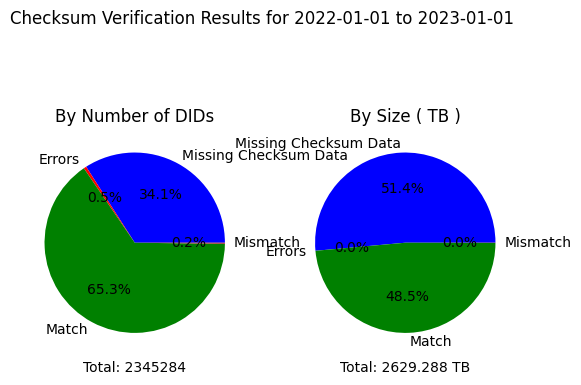

In [19]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)
fig.suptitle(f"Checksum Verification Results for {date_start.strftime('%Y-%m-%d')} to {date_end.strftime('%Y-%m-%d')}")

axs[0].title.set_text('By Number of DIDs')
axs[0].pie([num_missing_checksums, num_errors, num_verified_checksums, num_mismatch_checksums], labels=['Missing Checksum Data', 'Errors', 'Match', 'Mismatch'], colors=['blue', 'red', 'green', 'brown'], autopct='%1.1f%%')
axs[0].xaxis.set_label_text('Total: ' + str(num_potential_checksum_verification))

axs[1].title.set_text('By Size ( TB )')
axs[1].pie([size_missing_checksum, size_errors, size_verified, size_mismatch], labels=['Missing Checksum Data', 'Errors', 'Match', 'Mismatch'], colors=['blue', 'red', 'green', 'brown'], autopct='%1.1f%%')
axs[1].xaxis.set_label_text(f'Total: {size_potential_checksum_verification} TB')


plt.show()

## Save Mismatched Checksums

In [20]:
df_bad_replicas.to_csv(f'data/outputs/{date_start_str}-{date_end_str}_checksum_mismatch.csv', index=False)

## Monthly Plots

In [21]:
consistent_dids_in_time_range['month_year'] = list(zip(consistent_dids_in_time_range['month'], consistent_dids_in_time_range['year'])) 
dids_missing_checksums['month_year'] = list(zip(dids_missing_checksums['month'], dids_missing_checksums['year']))



/var/folders/0x/zbc_xnv17ggfqczysm3_5g_80000gn/T/ipykernel_85622/2443347236.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consistent_dids_in_time_range['month_year'] = list(zip(consistent_dids_in_time_range['month'], consistent_dids_in_time_range['year']))


In [22]:
print(date_start, date_end)

2022-01-01 00:00:00 2023-01-01 00:00:00


In [23]:
consistent_dids_in_time_range["month_year"].unique()

array([(5, 2022), (6, 2022), (8, 2022), (9, 2022), (11, 2022), (12, 2022)],
      dtype=object)

In [24]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
pd.options.plotting.backend='plotly'


In [25]:
fig = make_subplots(
    rows=len(consistent_dids_in_time_range["month_year"].unique()), 
    cols=2,
    specs=[[{"type": "pie"}, {"type": "pie"}]] * len(consistent_dids_in_time_range["month_year"].unique()),
    row_titles=[f"{month}/{year}" for month, year in consistent_dids_in_time_range["month_year"].unique()],
    column_titles=["Count", "Size"]
)

for index, month_year in enumerate(consistent_dids_in_time_range["month_year"].unique()):
    month, year = month_year
    monthly_num_potential_checksum_verification = len(consistent_dids_in_time_range[(consistent_dids_in_time_range['month'] == month) & (consistent_dids_in_time_range['year'] == year)])
    monthly_num_missing_checksums = len(dids_missing_checksums[(dids_missing_checksums['month'] == month) & (dids_missing_checksums['year'] == year)])
    monthly_num_errors = len(errors[(errors['month'] == month) & (errors['year'] == year)])
    monthly_num_verifiable = len(consistent_dids_in_time_range[(consistent_dids_in_time_range['month'] == month) & (consistent_dids_in_time_range['year'] == year) & consistent_dids_in_time_range['path'].isin(entries['path'])])
    monthly_num_verified_checksums = len(df_verified_replicas[(df_verified_replicas['month_x'] == month) & (df_verified_replicas['year_x'] == year)])

    monthly_size_potential_checksum_verification = bytesToTB(consistent_dids_in_time_range[(consistent_dids_in_time_range['month'] == month) & (consistent_dids_in_time_range['year'] == year)]['size'].sum())
    monthly_size_missing_checksum = bytesToTB(dids_missing_checksums[(dids_missing_checksums['month'] == month) & (dids_missing_checksums['year'] == year)]['size'].sum())
    monthly_size_errors = bytesToTB(errors[(errors['month'] == month) & (errors['year'] == year)]['size_bytes'].sum())
    monthly_size_verifiable = bytesToTB(checksum_verification_df[(checksum_verification_df['month'] == month) & (checksum_verification_df['year'] == year)]['size'].sum())
    monthly_size_verified = bytesToTB(df_verified_replicas[(df_verified_replicas['month_x'] == month) & (df_verified_replicas['year_x'] == year)]['size_x'].sum())
    monthly_size_mismatch = bytesToTB(df_bad_replicas[(df_bad_replicas['month_x'] == month) & (df_bad_replicas['year_x'] == year)]['size_x'].sum())

    # print(f"Month: {month}/{year}")
    # print(f"Potential DIDs for checksum verification: {monthly_num_potential_checksum_verification}")
    # print(f"Missing checksum information: {monthly_num_missing_checksums}")
    # print(f"Errors: {monthly_num_errors}")
    # print(f"Total verifiable DIDs: {monthly_num_verifiable}")
    # print(f"Verified Replicas (matching checksums): {monthly_num_verified_checksums}")
    # print(f"Checksum Mismatch: {monthly_num_verifiable - monthly_num_verified_checksums}")

    # print(f"Potential size for checksum verification: {monthly_size_potential_checksum_verification} TB")
    # print(f"Missing Checksum Info for : {monthly_size_missing_checksum} TB")
    # print(f"Errors: {monthly_size_errors} TB")
    # print(f"Total verifiable size: {monthly_size_verifiable} TB")
    # print(f"Verified Size (matching checksums): {monthly_size_verified} TB")
    # print(f"Checksum Mismatch: {monthly_size_mismatch} TB")

    fig.add_trace(
        go.Pie(
            textinfo='label+percent',
            titleposition='bottom center',
            labels=['Missing Checksum Data', 'Errors', 'Match', 'Mismatch'],
            values=[monthly_num_missing_checksums, monthly_num_errors, monthly_num_verified_checksums, monthly_num_verifiable - monthly_num_verified_checksums],
            title=f"Count: {monthly_num_potential_checksum_verification}",
            marker=dict(colors=['blue', 'red', 'green', 'brown'])
        ),
        row=index + 1,
        col=1,
    )

    fig.add_trace(
        go.Pie(
            textinfo='label+percent',
            titleposition='bottom center',
            labels=['Missing Checksum Data', 'Errors', 'Match', 'Mismatch'],
            values=[monthly_size_missing_checksum, monthly_size_errors, monthly_size_verified, monthly_size_mismatch],
            title=f"Size: {monthly_size_potential_checksum_verification} TB",
            marker=dict(colors=['blue', 'red', 'green', 'brown'])
        ),
        row=index + 1,
        col=2,
    )

fig.update_layout(height=3000, width=1000, title_text=f"SEAL RSE: Monthly Checksum Verification Report: {start_date} to {end_date}")
fig.show()

### Save the results of monthly plots

In [26]:
fig.write_html(f"reports/{start_date}-{end_date}_monthly_checksum_verification.html")
fig.write_image(f"reports/{start_date}-{end_date}_monthly_checksum_verification.png")

In [28]:
# save the data from 12/2022 for missing checksums

dids_missing_checksums_122022 = dids_missing_checksums[dids_missing_checksums['month'] == 12]

dids_missing_checksums_122022.to_csv(f'data/outputs/{date_start_str}-{date_end_str}_dids_missing_checksums_122022.csv', index=False)
